# Credit Card Fraud EDA

Initial profiling of the `creditcard.csv` dataset to understand class imbalance, feature distributions, and data quality signals.

In [1]:
from pathlib import Path

import numpy as np
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

try:
    from IPython import get_ipython
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

DATA_PATH = Path("../../data/raw/creditcard_fraud/creditcard.csv").resolve()
DATA_PATH

PosixPath('/Users/ivy/Desktop/project/fusionguard-analytics/data/raw/creditcard_fraud/creditcard.csv')

In [2]:
df = pd.read_csv(DATA_PATH)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df_shape = df.shape
df_types = df.dtypes.value_counts()

print("Shape:", df_shape)
df_types

Shape: (284807, 31)


float64    30
int64       1
Name: count, dtype: int64

In [4]:
numeric_summary = df.describe().T
numeric_summary["skew"] = df.skew(numeric_only=True)
numeric_summary["iqr"] = numeric_summary["75%"] - numeric_summary["25%"]
numeric_summary.head()

,count,mean,std,min,25%,50%,75%,max,skew,iqr
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000,-0.035568,85119.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930,-3.280667,2.236015
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729,-4.624866,1.402274
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558,-2.240155,1.917560
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344,0.676292,1.591981


In [5]:
skewness = df.skew(numeric_only=True).sort_values(key=lambda s: s.abs(), ascending=False)
skewness.head(10)

Class     23.997579
Amount    16.977724
V28       11.192091
V8        -8.521944
V23       -5.875140
V2        -4.624866
V17       -3.844914
V21        3.592991
V1        -3.280667
V7         2.553907
dtype: float64

In [6]:
missing = (df.isna().sum() / len(df)).sort_values(ascending=False)
if missing.eq(0).all():
    print("No missing values detected.")
else:
    missing[missing > 0]

No missing values detected.


In [7]:
class_counts = df["Class"].value_counts().rename({0: "Legit", 1: "Fraud"})
class_share = (class_counts / class_counts.sum()).sort_values(ascending=False)
display(pd.DataFrame({"count": class_counts, "share": class_share}))


,count,share
Class,,
Legit,284315,0.998273
Fraud,492,0.001727


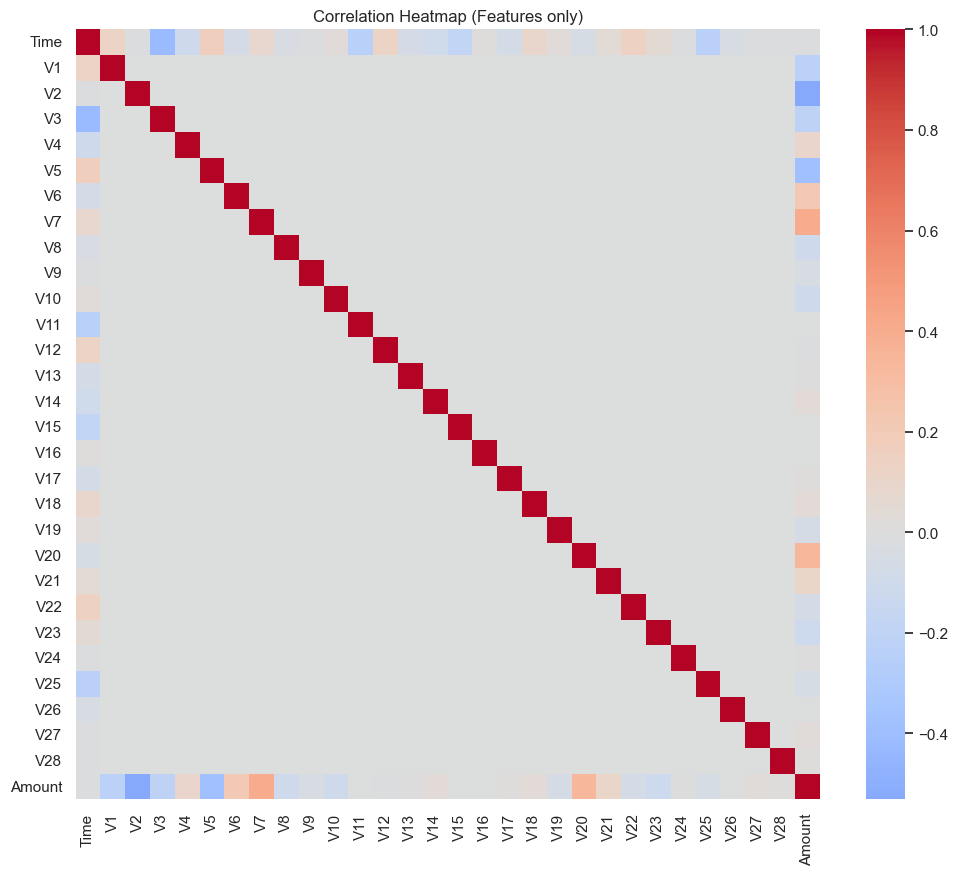

In [8]:
corr_matrix = df.drop(columns=['Class']).corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Features only)')
plt.show()

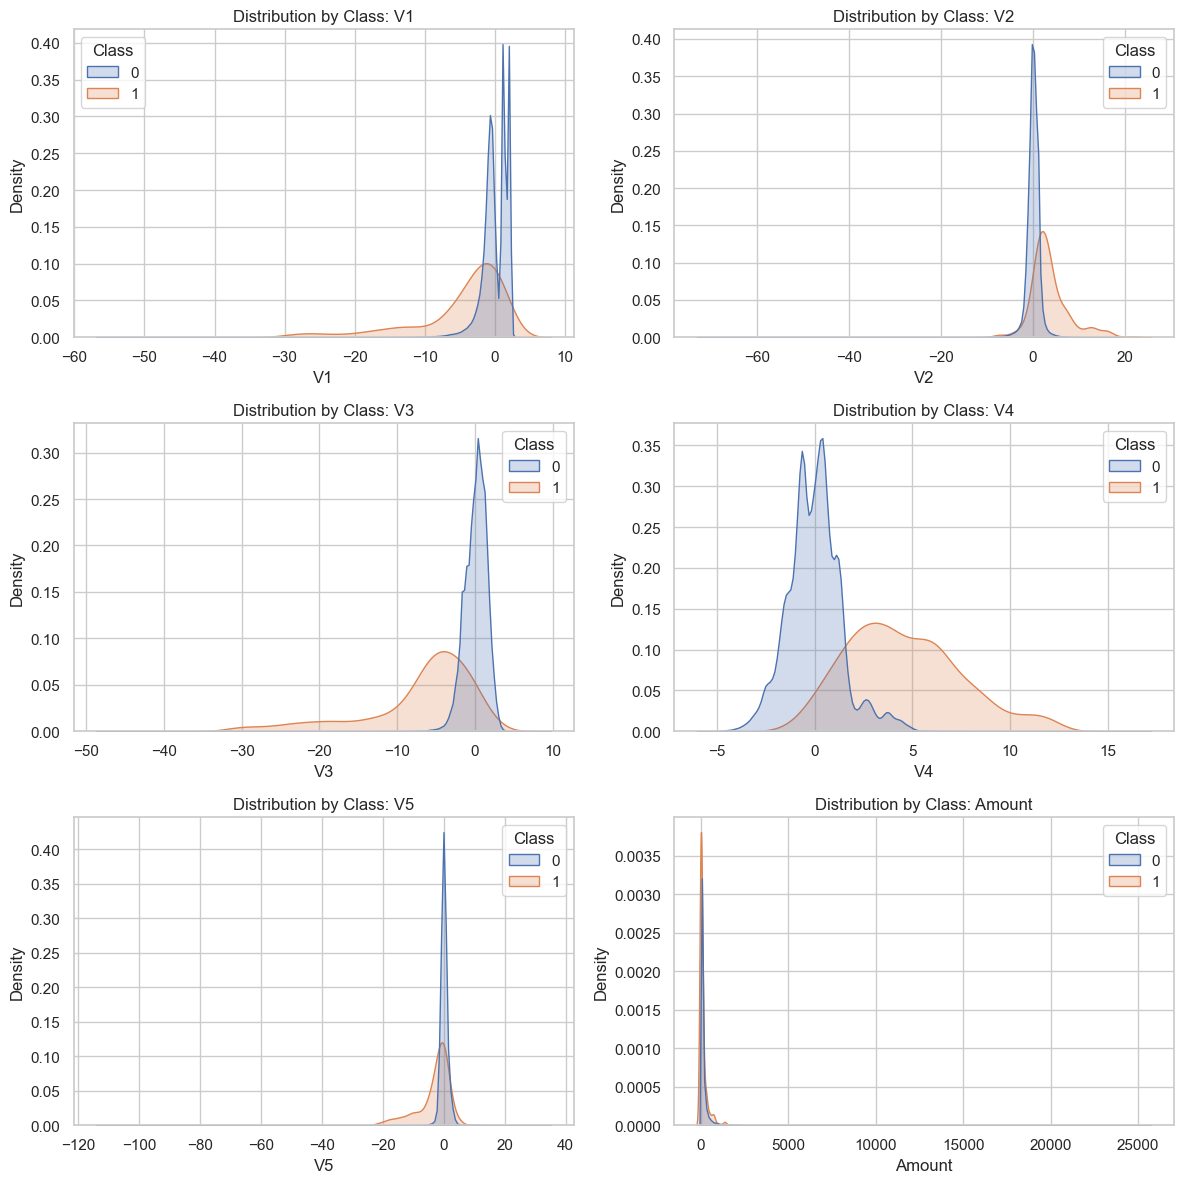

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
sample_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'Amount']

for ax, feature in zip(axes.flatten(), sample_features):
    sns.kdeplot(data=df, x=feature, hue='Class', common_norm=False, ax=ax, fill=True)
    ax.set_title(f'Distribution by Class: {feature}')

plt.tight_layout()
plt.show()

## Candidate Data Quality Checks

- Class label presence (`Class` should only contain 0 or 1).
- No missing values across numeric features.
- Transaction `Amount` must be non-negative.
- Feature ranges should stay within observed bounds (flag drift).
- Class imbalance ratio monitoring to detect ingestion issues.